In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 13 02:41:31 2018

@author: dhritiman
"""

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

x_train, train_labels = load_mnist('/Users/dhritiman/Documents/Documents - Dhritiman’s MacBook Pro/GitHub/fashion-mnist/data/fashion', kind='train')
x_test, test_labels = load_mnist('/Users/dhritiman/Documents/Documents - Dhritiman’s MacBook Pro/GitHub/fashion-mnist/data/fashion', kind='t10k')

In [4]:
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size,img_size)
num_classes = 10

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [8]:
# Image plotter
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

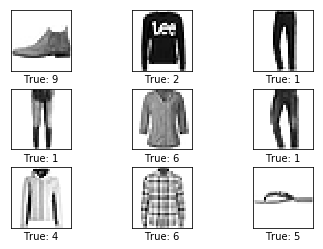

In [9]:
# Plot first 10 test set images
images10 = x_test[0:9]
cls_true = test_labels[0:9]
plot_images(images=images10, cls_true=cls_true)

In [10]:
# One-Hot Encoding
# Train Set
tmp_train = np.zeros((x_train.shape[0], 10))
for i in range(len(tmp_train)):
    tmp_train[i][train_labels[i]] = 1

# Test Set
tmp_test = np.zeros((x_test.shape[0], 10))
for i in range(len(tmp_test)):
    tmp_test[i][test_labels[i]] = 1


train_labels_hot_enoded = tmp_train
test_labels_hot_enoded = tmp_test

In [11]:
# TensorFlow work ##########################

# Holds the images that are input to the Tensorflow graph
x = tf.placeholder(tf.float32, [None, img_size_flat])

# Holds the true labels associated with the images that were input in the placeholder variable x
y_true = tf.placeholder(tf.float32, [None, num_classes])

# Holds the the true class of each image in the placeholder variable x
y_true_cls = tf.placeholder(tf.int64, [None])


# Holds the weights 
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))


# Holds the biases
biases = tf.Variable(tf.zeros([num_classes]))

#  Model: This simple mathematical model multiplies the images in the placeholder variable x with the weights and then adds the biases.
logits = tf.matmul(x, weights) + biases

# Normalizing logits
y_pred = tf.nn.softmax(logits)

# Index of largest element in each row of y_pred:
y_pred_cls = tf.argmax(y_pred, axis=1)

# Cross Entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

# Average cross entropy of all images as a scalar value
cost = tf.reduce_mean(cross_entropy)

# Optimizes the model by minimizing cross entropy
optimizer = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(cost)

# Few more performance measures ##########################

# Boolean vector whether the predicted class equals the true class of each image
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# This calculates the classification accuracy by first type-casting the vector 
# of booleans to floats, so that False becomes 0 and True becomes 1, and then
#  calculating the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Creating a TensorFlow Session
session = tf.Session()

# Initializing the variables- weights and biases
session.run(tf.global_variables_initializer())

# Using Batch Gradient Descent
batch_size = 256

import random

In [12]:
# Function to gradually improve weights and biases with each optimization iteration
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        indices = random.sample(range(len(x_train)), batch_size)
        x_batch = x_train[indices]
        y_true_batch = train_labels_hot_enoded[indices]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)


feed_dict_test = {x: x_test,
                  y_true: test_labels_hot_enoded,
                  y_true_cls: test_labels}

def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [13]:
optimize(num_iterations=5000)
print_accuracy()

Accuracy on test-set: 78.8%


In [14]:
optimize(num_iterations=30000)
print_accuracy()

Accuracy on test-set: 77.1%
